In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import lhapdf
import matplotlib.pyplot as plt
import csv
import sys
import keras_tuner as kt

In [2]:
Org_Data_path = 'Pseudodata/'
save_path = 'SIDIS_Models/rep'
HERMES13p= 'HERMES13p_Pseudo.csv'
SIDIS_Repl_Folder = 'SIDIS_Replica_Data'
Losses_Folder = 'SIDIS_Replicas_Losses'
herm13p = pd.read_csv(Org_Data_path + HERMES13p).dropna(axis=0, how='all').dropna(axis=1, how='all')
df = pd.concat([herm13p])

In [3]:
Hidden_Layers=2
Nodes_per_HL=100
Learning_Rate = 0.005
EPOCHS = 500
L1_reg = 10**(-12)
modify_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.9,patience=400,mode='auto')
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=200)
uncert_frac = 1

In [4]:
class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()
    
    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]

In [5]:
def chisquare(y, yhat, err):
    return np.sum(((y - yhat)/err)**2)

def pperp2avgVal(a,b,z):
    return a + b*(z**2)

def kBM2Avg(m1,kperp2Avg):
    temp=((m1**2)*kperp2Avg)/((m1**2)+kperp2Avg)
    return temp

def pc2Avg(pperp2Avg,mc):
    temp = ((mc**2)*pperp2Avg)/((mc**2)+pperp2Avg)
    return temp

def phT2Avg(pperp2Avg,kperp2Avg,z):
    temp = pperp2Avg + (kperp2Avg)*z**2
    return temp

def pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg):
    temp = pc2Avg(pperp2Avg,mc) + (z**2)*kBM2Avg(m1,kperp2Avg)
    return temp


def NCq(had,flavor,z):
    gamma=1.06
    delta=0.07
    temp_zfactor=(z**gamma)*((1-z)**(delta))*((gamma+delta)**(gamma+delta))/((gamma**gamma)*(delta**delta))
    if((str(had)=="pi+")&(flavor==2)):
        MCv = 0.49
    elif((str(had)=="pi+")&(flavor==-1)):
        MCv = 0.49
    elif((str(had)=="pi-")&(flavor==1)):
        MCv = 0.49
    elif((str(had)=="pi-")&(flavor==-2)):
        MCv = 0.49
    else:
        MCv = -1
    tempNCq=MCv*temp_zfactor
    return tempNCq



def pp2avg(z):
    return 0.2 + 0.5*(z**2)

In [6]:
def A0_cosphi_BM(y,z,pht,m1,mc,QQ,kperp2Avg,pperp2Avg,eCharg):
    temp1 = (2*(2-y)*(tf.sqrt(1-y)))/(1+(1-y)**2)
    temp2 = (2*eCharg*pht)/(m1*mc*tf.sqrt(QQ))
    temp3 = (pperp2Avg)/(pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg)**4)
    temp4 = tf.exp(pht**2/pperp2Avg - pht**2/pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg))
    temp5 = ((kBM2Avg(m1,kperp2Avg)**2)*(pc2Avg(pperp2Avg,mc)**2))/(kperp2Avg*pperp2Avg)
    temp6 = (z**2)*kBM2Avg(m1,kperp2Avg)*(pht**2 - pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg))+ pc2Avg(pperp2Avg,mc)*pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg)
    tempfinal = temp1*temp2*temp3*temp4*temp5*temp6
    return tempfinal


def A0_cos2phi_BM(y,z,pht,m1,mc,QQ,kperp2Avg,pperp2Avg,eCharg):
    temp1 = (2*(2-y))/(1+(1-y)**2)
    temp2 = (-eCharg*(pht**2))/(m1*mc)
    temp3 = (pperp2Avg)/(pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg)**3)
    temp4 = tf.exp(pht**2/pperp2Avg - pht**2/pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg))
    temp5 = ((kBM2Avg(m1,kperp2Avg)**2)*(pc2Avg(pperp2Avg,mc)**2))/(kperp2Avg*pperp2Avg)
    temp6 = (z**2)*kBM2Avg(m1,kperp2Avg)*(pht**2 - pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg))+ pc2Avg(pperp2Avg,mc)*pht2avgBM(pperp2Avg,mc,z,m1,kperp2Avg)
    tempfinal = temp1*temp2*temp3*temp4*temp5*temp6
    return tempfinal


def A0_cosphi_Cahn(y,z,pht,QQ,kperp2Avg,pperp2Avg,eCharg):
    temp1 = (2*(2-y)*(tf.sqrt(1-y)))/(1+(1-y)**2)
    temp2 = (-2*eCharg*pht)/(tf.sqrt(QQ))
    temp3 = (z*kperp2Avg)/(phT2Avg(pperp2Avg,kperp2Avg,z))
    tempfinal = temp1*temp2*temp3
    return tempfinal


def A0_cos2phi_Cahn(y,z,pht,QQ,kperp2Avg,pperp2Avg,eCharg):
    temp1 = (2*(2-y))/(1+(1-y)**2)
    temp2 = (2*eCharg*pht**pht)/(QQ)
    temp3 = (z*z*kperp2Avg*kperp2Avg)/(phT2Avg(pperp2Avg,kperp2Avg,z)**2)
    tempfinal = temp1*temp2*(temp3**2)
    return tempfinal

def A0_BM(y,z,QQ,pht,m1,mc,kperp2Avg,pperp2Avg,eCharg):
    temp = A0_cosphi_BM(y,z,pht,m1,mc,QQ,kperp2Avg,pperp2Avg,eCharg) - tf.sqrt(QQ)*A0_cos2phi_BM(y,z,pht,m1,mc,QQ,kperp2Avg,pperp2Avg,eCharg)
    return temp


def A0_Cahn(y,z,QQ,pht,m1,mc,kperp2Avg,pperp2Avg,eCharg):
    temp = A0_cosphi_Cahn(y,z,pht,QQ,kperp2Avg,pperp2Avg,eCharg) - tf.sqrt(QQ)*A0_cos2phi_Cahn(y,z,pht,QQ,kperp2Avg,pperp2Avg,eCharg)
    return temp
    

In [7]:
A0_BM(0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0738123>

In [8]:
A0_Cahn(0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.54144>

In [9]:
def create_nn_model(name, hidden_layers=Hidden_Layers, activation='relu'):
    inp = tf.keras.Input(shape=(1))
    #width = hp.Int('units', min_value=32, max_value=512, step=32)
    width = 64
    #Norm_inp = tf.keras.layers.BatchNormalization()(inp)
    #initializer = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=None)
    initializer = tf.keras.initializers.RandomUniform(minval=-0.1,maxval=0.1,seed=None)
    #initializer = tf.keras.initializers.Zeros() 0.00000000
    x = tf.keras.layers.Dense(width, activation=activation, kernel_initializer = initializer, activity_regularizer=tf.keras.regularizers.L1(L1_reg))(inp)
    x1 = tf.keras.layers.Dense(width, activation=activation, kernel_initializer = initializer, activity_regularizer=tf.keras.regularizers.L1(L1_reg))(x)
#     x2 = tf.keras.layers.Dense(width, activation=activation, kernel_initializer = initializer, activity_regularizer=tf.keras.regularizers.L1(L1_reg))(x1)
#     x3 = tf.keras.layers.Dense(width, activation=activation, kernel_initializer = initializer, activity_regularizer=tf.keras.regularizers.L1(L1_reg))(x2)
#     x4 = tf.keras.layers.Dense(width, activation=activation, kernel_initializer = initializer, activity_regularizer=tf.keras.regularizers.L1(L1_reg))(x3)
#     x5 = tf.keras.layers.Dense(width, activation=activation, kernel_initializer = initializer, activity_regularizer=tf.keras.regularizers.L1(L1_reg))(x4)
    # x6 = tf.keras.layers.Dense(width, activation=activation, kernel_initializer = initializer, activity_regularizer=tf.keras.regularizers.L1(L1_reg))(x5)
    # x7 = tf.keras.layers.Dense(width, activation=activation, kernel_initializer = initializer, activity_regularizer=tf.keras.regularizers.L1(L1_reg))(x6)
    nnout = tf.keras.layers.Dense(1, kernel_initializer = initializer)(x1)
    mod = tf.keras.Model(inp, nnout, name=name)
    return mod


In [10]:
def SIDIS_Model():
    x = tf.keras.Input(shape=(1), name='x')
    z = tf.keras.Input(shape=(1), name='z')
    y = tf.keras.Input(shape=(1), name='y')
    QQ = tf.keras.Input(shape=(1), name='Q2')
    phT = tf.keras.Input(shape=(1), name='phT')
    uexpr = tf.keras.Input(shape=(1), name='uexpr')
    ubarexpr = tf.keras.Input(shape=(1), name='ubarexpr')
    dexpr = tf.keras.Input(shape=(1), name='dexpr')
    dbarexpr = tf.keras.Input(shape=(1), name='dbarexpr')
    sexpr = tf.keras.Input(shape=(1), name='sexpr')
    sbarexpr = tf.keras.Input(shape=(1), name='sbarexpr')
    
#     kperp2Avg=0.03
#     pperp2Avg=0.12
#     eCharg = 1
#     m1 = 0.1
#     mc = 0.5
    kperp2Avg=0.03
    pperp2Avg = pp2avg(z)
    eCharg = 1
    m1 = 0.3
    mc = 1.22

    NNs=[]
    for i in ['nnu','nnubar','nnd','nndbar','nns','nnsbar']:
        NNs.append(create_nn_model(i)(x))

    nncomb = tf.keras.layers.Concatenate()(NNs)
    denominator = tf.keras.layers.Add()([uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr])
    exprcomb = tf.keras.layers.Concatenate()([uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr])
    numerator = tf.keras.layers.Dot(axes=1)([nncomb, exprcomb])
    quo = Quotient()([numerator, denominator])
    #zpht = tf.keras.layers.Concatenate()([z, phT])
    a0 = A0_BM(y,z,QQ,phT,m1,mc,kperp2Avg,pperp2Avg,eCharg)
    a0_C = A0_Cahn(y,z,QQ,phT,m1,mc,kperp2Avg,pperp2Avg,eCharg)
    temp_BM = tf.keras.layers.Multiply()([a0, quo])
    temp_Asym = tf.keras.layers.Add()([temp_BM,a0_C])
    return tf.keras.Model([x, y, z, phT, QQ, uexpr, ubarexpr, dexpr, dbarexpr, sexpr, sbarexpr],
                         temp_Asym)

In [11]:
NCq(str('pi+'),2,0.1)*np.array([1,2,3,4])

array([0.05507958, 0.11015916, 0.16523874, 0.22031832])

In [12]:
class DataSIDIS(object):
    # def __init__(self, pdfset='cteq61',
    #              ff_PIp='NNFF10_PIp_nlo', ff_PIm='NNFF10_PIm_nlo', ff_PIsum='NNFF10_PIsum_nlo',
    #              ff_KAp='NNFF10_KAp_nlo', ff_KAm='NNFF10_KAm_nlo'):
    def __init__(self, pdfset='cteq61',
                 ff_PIp='DSS14_NLO_Pip', ff_PIm='DSS14_NLO_Pim', ff_PIsum='DSS14_NLO_PiSum',
                 ff_KAp='DSS17_NLO_KaonPlus', ff_KAm='DSS17_NLO_KaonMinus'):
        '''
        Get data in proper format for neural network
        '''
        self.pdfData = lhapdf.mkPDF(pdfset)
        self.ffDataPIp = lhapdf.mkPDF(ff_PIp, 0)
        self.ffDataPIm = lhapdf.mkPDF(ff_PIm, 0)
        self.ffDataPIsum = lhapdf.mkPDF(ff_PIsum, 0)
        self.ffDataKAp = lhapdf.mkPDF(ff_KAp, 0)
        self.ffDataKAm = lhapdf.mkPDF(ff_KAm, 0)
        # needs to be extended to generalize for kaons
        self.eu = 2/3
        self.eubar = -2/3
        self.ed = -1/3
        self.edbar = 1/3
        self.es = -1/3
        self.esbar = 1/3
        
        self.gamma=1.06
        self.delta=0.07

        self.ffDict = {0: self.ffDataPIp,
                       1: self.ffDataPIm,
                       2: self.ffDataPIsum,
                       3: self.ffDataKAp,
                       4: self.ffDataKAm}

    def pdf(self, flavor, x, QQ):
        return np.array([self.pdfData.xfxQ2(flavor, ax, qq) for ax, qq in zip(x, QQ)])

    
    def ff(self, func, flavor, z, QQ):
        return np.array([func.xfxQ2(flavor, az, qq) for az, qq in zip(z, QQ)])
    
    
    def NCqv(self,had,flavor,z):
        temp_zfactor=(z**self.gamma)*((1-z)**(self.delta))*((self.gamma+self.delta)**(self.gamma+self.delta))/((self.gamma**self.gamma)*(self.delta**self.delta))
        if((str(had)=="pi+")&(flavor==2)):
            MCv = 0.49
        elif((str(had)=="pi+")&(flavor==-1)):
            MCv = 0.49
        elif((str(had)=="pi-")&(flavor==1)):
            MCv = 0.49
        elif((str(had)=="pi-")&(flavor==-2)):
            MCv = 0.49
        else:
            MCv = -1
        tempNCq=MCv*temp_zfactor
        return np.array(tempNCq)

    
    def makeData(self, df, hadrons, dependencies):

        data = {'x': [],
             'y': [],
             'z': [],
             'phT': [],
             'Q2': [],
             'uexpr': [],
             'ubarexpr': [],
             'dexpr': [],
             'dbarexpr': [],
             'sexpr': [],
             'sbarexpr': []}
        
        kins = {'hadron':[],
               'Q2': [],
               'x': [],
               'y': [],
               'z': [],
               'phT': [],
               '1D_dependence': []}

        asym = []
        err = []
        
        hads = []
        QQs =[]
        y = []
        deps = []

        df = df.loc[df['hadron'].isin(hadrons), :]
        df = df.loc[df['1D_dependence'].isin(dependencies), :]
        #X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
        for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
            sliced = df.loc[df['hadron'] == had, :]
            asym += list(sliced['Asym'])
            err += list(sliced['dAsym'])

            x = sliced['x']
            y = sliced['y']
            z = sliced['z']
            QQ = sliced['Q2']
            hads = sliced['hadron']
            QQs = sliced['Q2']
            phTs = sliced['phT']
            deps = sliced['1D_dependence']
            
            data['uexpr'] += list(self.eu**2 * self.pdf(2, x, QQ) * self.ff(self.ffDict[i], 2, z, QQ)*self.NCqv(i,2,z))
            data['ubarexpr'] += list(self.eubar**2 * self.pdf(-2, x, QQ) * self.ff(self.ffDict[i], -2, z, QQ)*self.NCqv(i,-2,z))
            data['dexpr'] += list(self.ed**2 * self.pdf(1, x, QQ) * self.ff(self.ffDict[i], 1, z, QQ)*self.NCqv(i,1,z))
            data['dbarexpr'] += list(self.edbar**2 * self.pdf(-1, x, QQ) * self.ff(self.ffDict[i], -1, z, QQ)*self.NCqv(i,-1,z))
            data['sexpr'] += list(self.es**2 * self.pdf(3, x, QQ) * self.ff(self.ffDict[i], 3, z, QQ)*self.NCqv(i,3,z))
            data['sbarexpr'] += list(self.esbar**2 * self.pdf(-3, x, QQ) * self.ff(self.ffDict[i], -3, z, QQ)*self.NCqv(i,-3,z))
            data['x'] += list(x)
            data['y'] += list(y)
            data['z'] += list(z)
            data['phT'] += list(phTs)
            data['Q2'] += list(QQ)
            
            kins['hadron']+= list(hads)
            kins['Q2']+= list(QQs)
            kins['x']+= list(x)
            kins['y']+= list(y)
            kins['z']+= list(z)
            kins['phT']+= list(phTs)
            kins['1D_dependence']+= list(deps)


        for key in data.keys():
            data[key] = np.array(data[key])
            
        for key in kins.keys():
            kins[key] = np.array(kins[key])

        return kins, data, data[dependencies[0]], np.array(asym), np.array(err)

In [13]:
def GenSIDISReplicaData(datasetdf):
    data_dictionary = {'hadron':[],
                      'Q2': [],
                      'x': [],
                      'y': [],
                      'z': [],
                      'phT': [],
                      'Asym':[],
                      'dAsym': [],
                      '1D_dependence': []}
    temp_hads = pd.unique(datasetdf['hadron'])
    temp_deps = pd.unique(datasetdf['1D_dependence'])
    for i in temp_hads:
        for j in temp_deps:
            T_Kins, T_Xplt, T_DEP, T_yplt, T_errplt = SIDISdataann.makeData(datasetdf, [str(i)], [str(j)])
            Yhat = np.random.normal(T_yplt, uncert_frac*T_errplt)
            Yerr = T_errplt
            data_dictionary['hadron']+= list(T_Kins['hadron'])
            data_dictionary['Q2']+= list(T_Kins['Q2'])
            data_dictionary['x']+= list(T_Kins['x'])
            data_dictionary['y']+= list(T_Kins['y'])
            data_dictionary['z']+= list(T_Kins['z'])
            data_dictionary['phT']+= list(T_Kins['phT'])
            data_dictionary['1D_dependence']+= list(T_Kins['1D_dependence'])
            data_dictionary['Asym']+= list(Yhat)
            data_dictionary['dAsym']+= list(Yerr)
    return pd.DataFrame(data_dictionary)

In [14]:
SIDISdataann = DataSIDIS()

In [15]:
GenSIDISReplicaData(df)

,hadron,Q2,x,y,z,phT,Asym,dAsym,1D_dependence
0,pi+,1.122807,0.002790,0.677647,0.343478,0.446575,0.655933,0.019565,x
1,pi+,1.473684,0.017060,0.503529,0.360870,0.397260,1.092141,0.013040,x
2,pi+,2.526316,0.113120,0.470588,0.365217,0.372603,0.699770,0.013040,x
3,pi+,4.596491,0.883950,0.456471,0.356522,0.356164,-0.054233,0.021425,x
4,pi+,2.000000,0.104255,0.381690,0.369565,0.356164,0.766282,0.016875,y
5,pi+,2.315789,0.085106,0.493840,0.365217,0.397260,0.704369,0.012190,y
6,pi+,2.526316,0.074468,0.615440,0.356522,0.421918,0.616887,0.012190,y
7,pi+,2.666667,0.065957,0.763390,0.339130,0.446575,0.462645,0.017812,y
8,pi+,2.310345,0.089362,0.128571,0.267500,0.339726,0.836385,0.013045,z
9,pi+,2.344828,0.091489,0.126190,0.345000,0.389041,0.833684,0.012115,z


In [17]:
def trn_tst(X, y, err, split=0.1):
    tstidxs = np.random.choice(list(range(len(y))), size=int(len(y)*split), replace=False)
    
    tst_X = {k: v[tstidxs] for k, v in X.items()}
    trn_X = {k: np.delete(v, tstidxs) for k, v in X.items()}
    
    tst_y = y[tstidxs]
    trn_y = np.delete(y, tstidxs)
    
    tst_err = err[tstidxs]
    trn_err = np.delete(err, tstidxs)
    
    return trn_X, tst_X, trn_y, tst_y, trn_err, tst_err

In [22]:
def run_replica(i):
    #replica_number = sys.argv[1]
    replica_number = i
    tempdf=GenSIDISReplicaData(df)
    tempdf.to_csv('rep'+str(replica_number)+'.csv')
    T_Kins, T_Xplt, T_DEP, T_yplt, T_errplt = SIDISdataann.makeData(tempdf, ['pi+', 'pi-', 'pi0', 'k+', 'k-'], ['x', 'y', 'z', 'phT'])
    
#     print(T_Xplt)
    trn_X, tst_X, trn_y, tst_y, trn_err, tst_err = trn_tst(T_Xplt, T_yplt, T_errplt)

    sivModel = SIDIS_Model()
    sivModel.compile(
        optimizer = tf.keras.optimizers.Adam(Learning_Rate),
        loss = tf.keras.losses.MeanSquaredError()
        )

    history = sivModel.fit(trn_X, trn_y, validation_data=(tst_X, tst_y), epochs=EPOCHS, callbacks=[modify_LR], batch_size=64, verbose=2)
    
    #sivModel.save(str(replica_number) + '.h5', save_format='h5')
    sivModel.save(save_path + str(replica_number) + '.h5', save_format='h5')
    tempdf = pd.DataFrame()
    tempdf["Train_Loss"] = history.history['loss']
    #[-100:]
    tempdf["Val_Loss"] = history.history['val_loss']
    #tempdf.to_csv('reploss_'+str(replica_number)+'.csv')
    tempdf.to_csv(str(Losses_Folder)+'/reploss_'+str(replica_number)+'.csv')
    plt.figure(1)
    plt.plot(history.history['loss'])
    #plt.savefig('train_loss'+str(replica_number)+'.pdf')
    plt.savefig(str(Losses_Folder)+'/Plots'+'/train_loss'+str(replica_number)+'.pdf')
    plt.figure(2)
    plt.plot(history.history['val_loss'])
    #plt.savefig('val_loss'+str(replica_number)+'.pdf')
    plt.savefig(str(Losses_Folder)+'/Plots'+'/val_loss'+str(replica_number)+'.pdf')

for i in range(0,2):    
    run_replica(i)

/home/isharauvaubuntu/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/500
1/1 - 2s - loss: 0.6032 - val_loss: 0.4583 - lr: 0.0050 - 2s/epoch - 2s/step
Epoch 2/500
1/1 - 0s - loss: 0.6025 - val_loss: 0.4576 - lr: 0.0050 - 36ms/epoch - 36ms/step
Epoch 3/500
1/1 - 0s - loss: 0.6016 - val_loss: 0.4568 - lr: 0.0050 - 40ms/epoch - 40ms/step
Epoch 4/500
1/1 - 0s - loss: 0.6005 - val_loss: 0.4558 - lr: 0.0050 - 40ms/epoch - 40ms/step
Epoch 5/500
1/1 - 0s - loss: 0.5993 - val_loss: 0.4547 - lr: 0.0050 - 43ms/epoch - 43ms/step
Epoch 6/500
1/1 - 0s - loss: 0.5979 - val_loss: 0.4535 - lr: 0.0050 - 45ms/epoch - 45ms/step
Epoch 7/500
1/1 - 0s - loss: 0.5963 - val_loss: 0.4520 - lr: 0.0050 - 42ms/epoch - 42ms/step
Epoch 8/500
1/1 - 0s - loss: 0.5944 - val_loss: 0.4504 - lr: 0.0050 - 44ms/epoch - 44ms/step
Epoch 9/500
1/1 - 0s - loss: 0.5923 - val_loss: 0.4485 - lr: 0.0050 - 51ms/epoch - 51ms/step
Epoch 10/500
1/1 - 0s - loss: 0.5899 - val_loss: 0.4463 - lr: 0.0050 - 43ms/epoch - 43ms/step
Epoch 11/500
1/1 - 0s - loss: 0.5872 - val_loss: 0.4439 - lr: 0.0050 - 46

Epoch 89/500
1/1 - 0s - loss: 0.0228 - val_loss: 0.0201 - lr: 0.0050 - 31ms/epoch - 31ms/step
Epoch 90/500
1/1 - 0s - loss: 0.0224 - val_loss: 0.0206 - lr: 0.0050 - 34ms/epoch - 34ms/step
Epoch 91/500
1/1 - 0s - loss: 0.0220 - val_loss: 0.0211 - lr: 0.0050 - 38ms/epoch - 38ms/step
Epoch 92/500
1/1 - 0s - loss: 0.0217 - val_loss: 0.0216 - lr: 0.0050 - 29ms/epoch - 29ms/step
Epoch 93/500
1/1 - 0s - loss: 0.0214 - val_loss: 0.0221 - lr: 0.0050 - 28ms/epoch - 28ms/step
Epoch 94/500
1/1 - 0s - loss: 0.0212 - val_loss: 0.0226 - lr: 0.0050 - 30ms/epoch - 30ms/step
Epoch 95/500
1/1 - 0s - loss: 0.0209 - val_loss: 0.0230 - lr: 0.0050 - 29ms/epoch - 29ms/step
Epoch 96/500
1/1 - 0s - loss: 0.0207 - val_loss: 0.0234 - lr: 0.0050 - 28ms/epoch - 28ms/step
Epoch 97/500
1/1 - 0s - loss: 0.0205 - val_loss: 0.0237 - lr: 0.0050 - 30ms/epoch - 30ms/step
Epoch 98/500
1/1 - 0s - loss: 0.0202 - val_loss: 0.0239 - lr: 0.0050 - 28ms/epoch - 28ms/step
Epoch 99/500
1/1 - 0s - loss: 0.0200 - val_loss: 0.0241 - lr

Epoch 176/500
1/1 - 0s - loss: 0.0119 - val_loss: 0.0405 - lr: 0.0050 - 33ms/epoch - 33ms/step
Epoch 177/500
1/1 - 0s - loss: 0.0119 - val_loss: 0.0405 - lr: 0.0050 - 34ms/epoch - 34ms/step
Epoch 178/500
1/1 - 0s - loss: 0.0118 - val_loss: 0.0406 - lr: 0.0050 - 32ms/epoch - 32ms/step
Epoch 179/500
1/1 - 0s - loss: 0.0118 - val_loss: 0.0406 - lr: 0.0050 - 33ms/epoch - 33ms/step
Epoch 180/500
1/1 - 0s - loss: 0.0118 - val_loss: 0.0406 - lr: 0.0050 - 31ms/epoch - 31ms/step
Epoch 181/500
1/1 - 0s - loss: 0.0117 - val_loss: 0.0406 - lr: 0.0050 - 57ms/epoch - 57ms/step
Epoch 182/500
1/1 - 0s - loss: 0.0117 - val_loss: 0.0406 - lr: 0.0050 - 38ms/epoch - 38ms/step
Epoch 183/500
1/1 - 0s - loss: 0.0116 - val_loss: 0.0406 - lr: 0.0050 - 44ms/epoch - 44ms/step
Epoch 184/500
1/1 - 0s - loss: 0.0116 - val_loss: 0.0406 - lr: 0.0050 - 46ms/epoch - 46ms/step
Epoch 185/500
1/1 - 0s - loss: 0.0116 - val_loss: 0.0406 - lr: 0.0050 - 39ms/epoch - 39ms/step
Epoch 186/500
1/1 - 0s - loss: 0.0115 - val_loss: 

KeyboardInterrupt: 

In [16]:
Models_folder = './SIDIS_Models'
folders_array=os.listdir(Models_folder)
OutputFolder='./NN_SIDIS_Fit_Results'
numreplicas_SIDIS=len(folders_array)
#numreplicas_SIDIS=5
print(numreplicas_SIDIS)

100


In [17]:
SIDISmodelsArray = []
# for i in range(numreplicas_SIDIS):
for i in range(20):
    testmodel = tf.keras.models.load_model(str(Models_folder)+'/' + str(folders_array[i]),custom_objects={'Quotient': Quotient})
    SIDISmodelsArray.append(testmodel)

/home/isharauvaubuntu/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [18]:
SIDISmodelsArray = np.array(SIDISmodelsArray)

In [19]:
def calc_yhat(model, X):
    return model.predict(X)

def BMAsym(df,numReplicas,hadron,dependence):
    T_Kins, T_Xplt, T_DEP, T_yplt, T_errplt = SIDISdataann.makeData(df, [hadron], [dependence])
    results = []
    for i in range(numReplicas):
        #folders_array
        #testmodel = tf.keras.models.load_model(str(Models_folder)+'/' + str(folders_array[i]),custom_objects={'A0': A0, 'Quotient': Quotient})
        #testmodel = tf.keras.models.load_model(str(Models_folder)+'/rep' + str(i) + '.h5',custom_objects={'A0': A0, 'Quotient': Quotient})
        testmodel = SIDISmodelsArray[i]
        results.append(list(calc_yhat(testmodel, T_Xplt)))
    return np.array(results)

In [20]:
def GenPseudo(datasetdf, numReplicas, numSigma=1):
    data_dictionary = {'hadron':[],
                      'Q2': [],
                      'x': [],
                      'z': [],
                      'phT': [],
                      'Asym':[],
                      'dAsym': [],
                      '1D_dependence': []}
    temp_hads = pd.unique(datasetdf['hadron'])
    temp_deps = pd.unique(datasetdf['1D_dependence'])
    SiversA = []
    SiversA_err = []
    for i in temp_hads:
        for j in temp_deps:
            T_Kins, T_Xplt, T_DEP, T_yplt, T_errplt = SIDISdataann.makeData(datasetdf, [str(i)], [str(j)])
            #T_Kins, T_Xplt, T_DEP, T_yplt, T_errplt = datann.makeData(datasetdf, ['pi+'], ['x'])
            results = BMAsym(datasetdf, numReplicas,i, j)
            Yhat = np.array(results.mean(axis=0))
            Yhat = Yhat.flatten()
            Yerr = np.array(results.std(axis=0))
            Yerr = Yerr.flatten()
            SiversA.append(Yhat)
            SiversA_err.append(Yerr)
            data_dictionary['hadron']+= list(T_Kins['hadron'])
            data_dictionary['Q2']+= list(T_Kins['Q2'])
            data_dictionary['x']+= list(T_Kins['x'])
            #data_dictionary['y']+= list(T_Kins['y'])
            data_dictionary['z']+= list(T_Kins['z'])
            data_dictionary['phT']+= list(T_Kins['phT'])
            data_dictionary['1D_dependence']+= list(T_Kins['1D_dependence'])
            data_dictionary['Asym']+= list(T_yplt)
            data_dictionary['dAsym']+= list(T_errplt)
            #print(Yhat)
    #print(np.concatenate(t_hads))
    data_dictionary['Asym'] = np.concatenate(SiversA)
    data_dictionary['dAsym'] = np.concatenate(SiversA_err)
    return pd.DataFrame(data_dictionary)

In [25]:
NN_Pseudo_SIDIS_HERMES13p=GenPseudo(herm13p, 20, numSigma=1)
NN_Pseudo_SIDIS_HERMES13p.to_csv(str(OutputFolder)+'/Result_SIDIS_HERMES13p_pseudo.csv')

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


In [21]:
eCharg = 1

def nnq(model, x, hadronstr):
    if not hadronstr in ['nnu', 'nnd', 'nns', 'nnubar', 'nndbar', 'nnsbar']:
        raise Exception('hadronstr must be one of nnu, nnd, nns, nnubar, nndbar, nnsbar')
    mod_out = tf.keras.backend.function(model.get_layer(hadronstr).input,
                                       model.get_layer(hadronstr).output)
    return mod_out(x)

def h(m1, kperp):
    kperp2Avg = 0.03
    return np.sqrt(2*eCharg)* (kperp/m1)* np.exp(-kperp**2/kBM2Avg(m1,kperp2Avg))/(np.pi*kperp2Avg)


def fqp(x, QQ, kperp2avg, kperp, flavor):
    #had = functions_new.Hadron()
    #had = DY_Hadron()
    had = DataSIDIS()
    #fq = had.pdf_DY(flavor, x, QQ)
    fq = had.pdf(flavor, x, QQ)
    return fq
#     return fq*(1/(np.pi*kperp2avg))*np.exp(-kperp**2/kperp2avg)
    
#kperp_vals=np.array(list(range(150)))/100
kperp_vals=np.array(np.linspace(0.001,0.2,500))
kperp_vals=tf.constant(kperp_vals) 
tempkperp2Avg = 0.03
fqpu = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, 2)
fqpd = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, 1)
fqps = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, 3)
fqpubar = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, -2)
fqpdbar = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, -1)
fqpsbar = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, -3)

In [22]:
#kBM2Avg(m1,kperp2Avg)
kBM2Avg(0.03,0.5)

0.0008983829107606308

In [27]:
fqpu

array([0.64136251])

In [128]:
h(0.03,0.5)

1.385529743335703e-122

In [23]:
def xsivdist(model, m1, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnq(model, np.array([x]), refDict[flavor])
    #nnqval = nnq(model , np.array([x]), refDict[flavor])[:,0] np.array([x])
    hval = h(m1, kperp)
    if(flavor == -3):
        fqpval = fqpsbar
    if(flavor == -2):
        fqpval = fqpubar
    if(flavor == -1):
        fqpval = fqpdbar
    if(flavor == 1):
        fqpval = fqpd
    if(flavor == 2):
        fqpval = fqpu
    if(flavor == 3):
        fqpval = fqps
    #fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    return ((nnqval*hval*fqpval)[0, :])


In [24]:
xsivdist(SIDISmodelsArray[0], 0.03, 0.1, 2.4, 0.03, 1, 0.03)

array([73.78722267])

In [25]:
def xsivdistFromReplicas(numReplicas, m1, x, QQ, kperp2avg, kperp):
    tempfu = []
    tempfd = []
    tempfs = []
    tempfubar = []
    tempfdbar = []
    tempfsbar = []
    for i in range(numReplicas):
        t = SIDISmodelsArray[i]
        tempfu.append(list(xsivdist(t, m1, x, QQ, kperp2avg, 2, kperp)))
        tempfd.append(list(xsivdist(t, m1, x, QQ, kperp2avg, 1, kperp)))
        tempfs.append(list(xsivdist(t, m1, x, QQ, kperp2avg, 3, kperp)))
        tempfubar.append(list(xsivdist(t, m1, x, QQ, kperp2avg, -2, kperp)))
        tempfdbar.append(list(xsivdist(t, m1, x, QQ, kperp2avg, -1, kperp)))
        tempfsbar.append(list(xsivdist(t, m1, x, QQ, kperp2avg, -3, kperp)))
    return np.array(tempfu),np.array(tempfubar),np.array(tempfd),np.array(tempfdbar),np.array(tempfs),np.array(tempfsbar)

In [26]:
xsivdistFromReplicas(2, 0.03, 0.1, 2.4, 0.03, 0.03)

(array([[57.64194699],
        [54.06797748]]),
 array([[5.44888741],
        [5.01997043]]),
 array([[73.78722267],
        [77.39951381]]),
 array([[18.95796913],
        [23.8623395 ]]),
 array([[4.89761992],
        [5.82896564]]),
 array([[0.29717903],
        [3.87301841]]))

In [27]:
def BMDistBandsCSVgen(numReplicas, x, QQ, kperp2avg, kperp, numSigma=1):
    data_dictionary={"kperp":[],"fu":[],"fuErr":[],"fubar":[],"fubarErr":[],"fd":[],"fdErr":[],"fdbar":[],"fdbarErr":[],"fs":[],"fsErr":[],"fsbar":[],"fsbarErr":[]}
    results = xsivdistFromReplicas(numReplicas,0.03, x, QQ, kperp2avg, kperp)
    tempfu = results[0].mean(axis=0)
    tempfuErr = results[0].std(axis=0)
    tempfubar = results[1].mean(axis=0)
    tempfubarErr = results[1].std(axis=0)
    tempfd = results[2].mean(axis=0)
    tempfdErr = results[2].std(axis=0)
    tempfdbar = results[3].mean(axis=0)
    tempfdbarErr = results[3].std(axis=0)
    tempfs = results[4].mean(axis=0)
    tempfsErr = results[4].std(axis=0)
    tempfsbar = results[5].mean(axis=0)
    tempfsbarErr = results[5].std(axis=0)
    kp = np.array(kperp)
    data_dictionary["kperp"]=kp
    data_dictionary["fu"]=tempfu
    data_dictionary["fuErr"]=tempfuErr
    data_dictionary["fubar"]=tempfubar
    data_dictionary["fubarErr"]=tempfubarErr
    data_dictionary["fd"]=tempfd
    data_dictionary["fdErr"]=tempfdErr
    data_dictionary["fdbar"]=tempfdbar
    data_dictionary["fdbarErr"]=tempfdbarErr
    data_dictionary["fs"]=tempfs
    data_dictionary["fsErr"]=tempfsErr
    data_dictionary["fsbar"]=tempfsbar
    data_dictionary["fsbarErr"]=tempfsbarErr
    return pd.DataFrame(data_dictionary)

In [28]:
fMBCSV = BMDistBandsCSVgen(20, 0.1, 2.4, 0.03, kperp_vals)
fMBCSV.to_csv(str(OutputFolder)+'/'+'SIDIS_BMfuncs_pseudo_v1.csv')

In [ ]:
fqpu = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, 2)
fqpd = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, 1)
fqps = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, 3)
fqpubar = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, -2)
fqpdbar = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, -1)
fqpsbar = fqp([0.1], [2.4], tempkperp2Avg, kperp_vals, -3)

In [75]:
def NNq(x,Nq,aq,bq):
    tempNNq = Nq*(x**aq)*((1-x)**(bq))*((aq+bq)**(aq+bq))/((aq**aq)*(bq**bq))
    return tempNNq

def NNqbar(x,Nq,aq,bq):
    tempNNq = Nq*(x**aq)*((1-x)**(bq))*((aq+bq)**(aq+bq))/((aq**aq)*(bq**bq))
    return tempNNq

#2*NNq(x,Nq,aq,bq)*h(tempM1,kp)*fqpu

def BMFuncQ(flavor,x,QQ,kp,fitresult):
    tempM1=fitresult[0]
    if(flavor==2):
        Nq=fitresult[1]
        aq=fitresult[2]
        bq=fitresult[3]
        tempsiv=2*NNq(x,Nq,aq,bq)*h(tempM1,kp)*fqpu
    if(flavor==1):
        Nq=fitresult[5]
        aq=fitresult[6]
        bq=fitresult[7]
        tempsiv=2*NNq(x,Nq,aq,bq)*h(tempM1,kp)*fqpd
    if(flavor==3):
        Nq=fitresult[9]
        aq=fitresult[10]
        bq=fitresult[11]
        tempsiv=2*NNq(x,Nq,aq,bq)*h(tempM1,kp)*fqps
    return tempsiv
    
def BMFuncAntiQ(flavor,x,QQ,kp,fitresult):
    tempM1=fitresult[0]
    if(flavor==-2):
        tempM1=fitresult[0]
        Nq=fitresult[4]
        tempsiv=2*NNqbar(x,Nq)*h(tempM1,kp)*fqpubar
    if(flavor==-1):
        tempM1=fitresult[0]
        Nq=fitresult[8]
        tempsiv=2*NNqbar(x,Nq)*h(tempM1,kp)*fqpdbar
    if(flavor==-3):
        tempM1=fitresult[0]
        Nq=fitresult[12]
        tempsiv=2*NNqbar(x,Nq)*h(tempM1,kp)*fqpsbar
    return tempsiv
    

def plotSiversQ(flavor,ParmResults,col):
    tempkT=np.array(np.linspace(0, 0.2))
    tempSiv=[BMFuncQ(flavor,0.1,2.4,tempkT[i],ParmResults) for i in range(0,len(tempkT))]
    plt.plot(tempkT,tempSiv, color = col)
    #return tempSiv

def plotSiversAntiQ(flavor,ParmResults,col):
    tempkT=np.array(np.linspace(0, 0.2))
    tempSiv=[BMFuncAntiQ(flavor,0.1,2.4,tempkT[i],ParmResults) for i in range(0,len(tempkT))]
    plt.plot(tempkT,tempSiv, color = col)

In [69]:
tempkTtst=np.array(np.linspace(0, 0.2))

In [70]:
tempkTtst

array([0.        , 0.00408163, 0.00816327, 0.0122449 , 0.01632653,
       0.02040816, 0.0244898 , 0.02857143, 0.03265306, 0.03673469,
       0.04081633, 0.04489796, 0.04897959, 0.05306122, 0.05714286,
       0.06122449, 0.06530612, 0.06938776, 0.07346939, 0.07755102,
       0.08163265, 0.08571429, 0.08979592, 0.09387755, 0.09795918,
       0.10204082, 0.10612245, 0.11020408, 0.11428571, 0.11836735,
       0.12244898, 0.12653061, 0.13061224, 0.13469388, 0.13877551,
       0.14285714, 0.14693878, 0.15102041, 0.15510204, 0.15918367,
       0.16326531, 0.16734694, 0.17142857, 0.1755102 , 0.17959184,
       0.18367347, 0.1877551 , 0.19183673, 0.19591837, 0.2       ])

In [71]:
test_pars=np.array([0.3,19.7,0.64,5,20,2.2,20,-15,5.4,18,-17,1.3,11,19.9,0,0,20,0,0])

In [76]:
print(BMFuncQ(2,0.1,2.4,tempkTtst,test_pars))

[ 0.          5.12691655 10.23108158 15.28991173 20.28115833 25.1830703
 29.97455208 34.63531473 39.14601885 43.48840781 47.64543005 51.60134932
 55.34184193 58.85407997 62.12680023 65.150358   67.91676563 70.41971587
 72.65458979 74.61844985 76.31001831 77.72964173 78.87924225 79.76225649
 80.38356308 80.74939997 80.86727261 80.7458543  80.39488    79.82503487
 79.04783896 78.07552931 76.92094073 75.59738665 74.11854111 72.49832307
 70.75078419 68.89000085 66.92997155 64.88452016 62.76720596 60.59124079
 58.36941389 56.1140247  53.83682381 51.54896218 49.26094873 46.98261596
 44.72309379 42.49079095]


In [79]:
CSVs_Folder = './NN_SIDIS_Fit_Results'
Plots_Folder = './NN_SIDIS_Plots'
Sivers_CSV_file = pd.read_csv(str(CSVs_Folder)+'/'+'SIDIS_BMfuncs_pseudo_v1.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
Sivers_CSV_df = pd.concat([Sivers_CSV_file])
t1= 0.01

# def QSiversPlots(tempdf):
#     tempKT = np.array(tempdf['kperp'])
#     tempfu = t1*np.array(tempdf['fu'])
#     tempfuErr = t1*np.array(tempdf['fuErr'])
#     tempfd = t1*np.array(tempdf['fd'])
#     tempfdErr = t1*np.array(tempdf['fdErr'])
#     tempfs = t1*0.1*np.array(tempdf['fs'])
#     tempfsErr = t1*np.array(tempdf['fsErr'])
#     plt.plot(tempKT, tempfu, 'b', label='$u$')
#     plt.fill_between(tempKT, tempfu-tempfuErr, tempfu+tempfuErr, facecolor='b', alpha=0.3)
#     plotSiversQ(2,test_pars, 'b')
#     plt.plot(tempKT, tempfd, 'r', label='$d$')
#     plt.fill_between(tempKT, tempfd-tempfdErr, tempfd+tempfdErr, facecolor='r', alpha=0.3)
#     plotSiversQ(1,test_pars, 'r')
#     plt.plot(tempKT, tempfs, 'g', label='$s$')
#     plt.fill_between(tempKT, tempfs-tempfsErr, tempfs+tempfsErr, facecolor='g', alpha=0.3)
#     plotSiversQ(3,test_pars, 'g')
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     #plt.ylim(-0.125,0.125)
#     plt.xlim(0,0.2)
#     plt.legend(loc=4,fontsize=20,handlelength=3)
#     plt.savefig(str(Plots_Folder)+'/'+'BMQ_SIDIS_DNN_v1.pdf', format='pdf', bbox_inches='tight')


def QSiversPlots(tempdf):
    tempKT = np.array(tempdf['kperp'])
    tempfu = np.array(tempdf['fu'])
    tempfuErr = np.array(tempdf['fuErr'])
    tempfd = np.array(tempdf['fd'])
    tempfdErr = np.array(tempdf['fdErr'])
    tempfs = np.array(tempdf['fs'])
    tempfsErr = np.array(tempdf['fsErr'])
    plt.plot(tempKT, tempfu, 'b', label='$u$')
    plt.fill_between(tempKT, tempfu-tempfuErr, tempfu+tempfuErr, facecolor='b', alpha=0.3)
    plotSiversQ(2,test_pars, 'b')
    plt.plot(tempKT, tempfd, 'r', label='$d$')
    plt.fill_between(tempKT, tempfd-tempfdErr, tempfd+tempfdErr, facecolor='r', alpha=0.3)
    plotSiversQ(1,test_pars, 'r')
    plt.plot(tempKT, tempfs, 'g', label='$s$')
    plt.fill_between(tempKT, tempfs-tempfsErr, tempfs+tempfsErr, facecolor='g', alpha=0.3)
    plotSiversQ(3,test_pars, 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylim(-0.125,0.125)
    plt.xlim(0,0.2)
    plt.legend(loc=4,fontsize=20,handlelength=3)
    plt.savefig(str(Plots_Folder)+'/'+'BMQ_SIDIS_DNN_v1.pdf', format='pdf', bbox_inches='tight')
    

def AntiQSiversPlots(tempdf):
    tempKT = np.array(tempdf['kperp'])
    tempfu = t1*np.array(tempdf['fubar'])
    tempfuErr = t1*np.array(tempdf['fubarErr'])
    tempfd = t1*np.array(tempdf['fdbar'])
    tempfdErr = t1*np.array(tempdf['fdbarErr'])
    tempfs = t1*np.array(tempdf['fsbar'])
    tempfsErr = 5*t1*np.array(tempdf['fsbarErr'])
    plt.plot(tempKT, tempfu, 'b', label='$\\bar{u}$')
    plt.fill_between(tempKT, tempfu-tempfuErr, tempfu+tempfuErr, facecolor='b', alpha=0.3)
    plotSiversAntiQ(-2,test_pars, 'b')
    plt.plot(tempKT, tempfd, 'r', label='$\\bar{d}$')
    plt.fill_between(tempKT, tempfd-tempfdErr, tempfd+tempfdErr, facecolor='r', alpha=0.3)
    plotSiversAntiQ(-1,test_pars, 'r')
    plt.plot(tempKT, tempfs, 'g', label='$\\bar{s}$')
    plt.fill_between(tempKT, tempfs-tempfsErr, tempfs+tempfsErr, facecolor='g', alpha=0.3)
    plotSiversAntiQ(-3,test_pars, 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylim(-0.125,0.125)
    plt.xlim(0,0.2)
    plt.legend(loc=4,fontsize=20,handlelength=3)
    plt.savefig(str(Plots_Folder)+'/'+'BM_AntiQ_SIDIS_NN_v1.pdf', format='pdf', bbox_inches='tight')

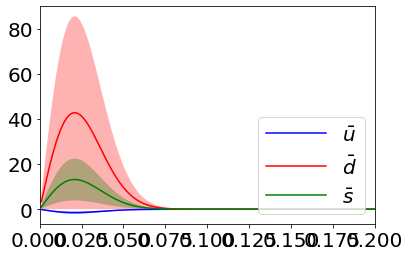

In [172]:
AntiQSiversPlots(Sivers_CSV_df)

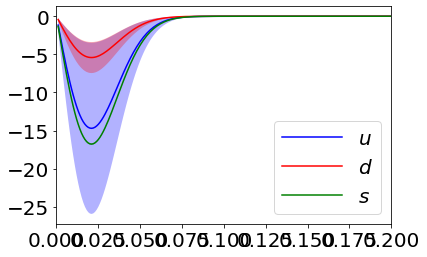

In [173]:
QSiversPlots(Sivers_CSV_df)

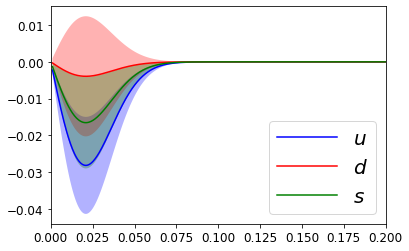

In [246]:
QSiversPlots(Sivers_CSV_df)

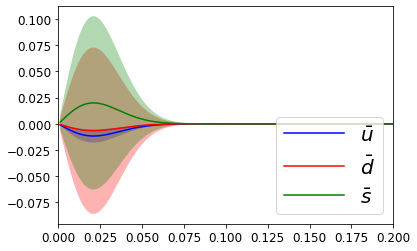

In [251]:
AntiQSiversPlots(Sivers_CSV_df)

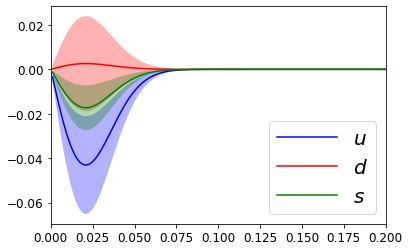

In [102]:
QSiversPlots(Sivers_CSV_df)

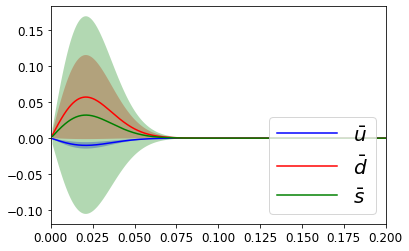

In [103]:
AntiQSiversPlots(Sivers_CSV_df)

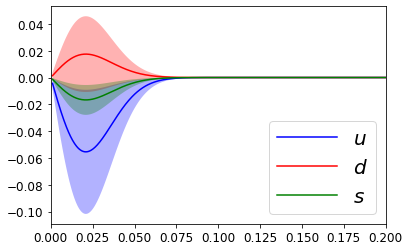

In [136]:
QSiversPlots(Sivers_CSV_df)

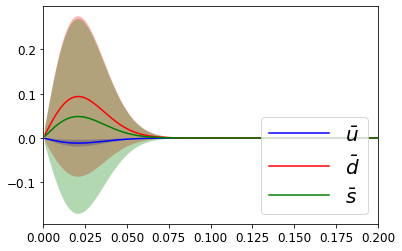

In [137]:
AntiQSiversPlots(Sivers_CSV_df)

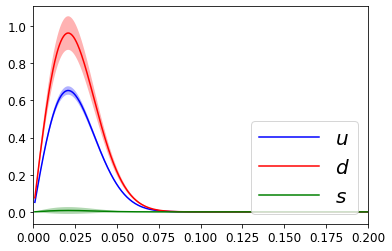

In [39]:
QSiversPlots(Sivers_CSV_df)

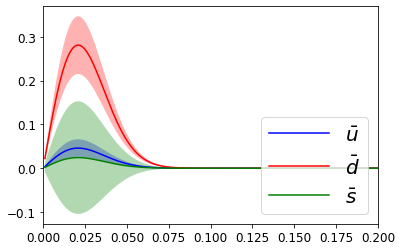

In [40]:
AntiQSiversPlots(Sivers_CSV_df)

In [33]:
test_pars=np.array([0.3,19.7,0.64,5,20,2.2,20,-15,5.4,18,-17,1.3,11,19.9,0,0,20,0,0])

<ipython-input-75-5de8d1320c54>:2: RuntimeWarning: invalid value encountered in double_scalars
  tempNNq = Nq*(x**aq)*((1-x)**(bq))*((aq+bq)**(aq+bq))/((aq**aq)*(bq**bq))


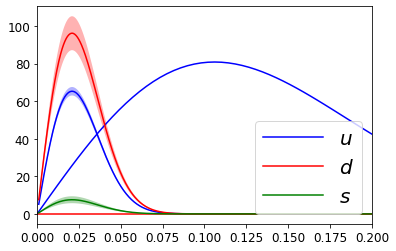

In [80]:
QSiversPlots(Sivers_CSV_df)

In [ ]:
#     plotSiversQ(2,test_pars, 'b')
#     plt.plot(tempKT, tempfd, 'r', label='$d$')
#     plt.fill_between(tempKT, tempfd-tempfdErr, tempfd+tempfdErr, facecolor='r', alpha=0.3)
#     plotSiversQ(1,test_pars, 'r')
#     plt.plot(tempKT, tempfs, 'g', label='$s$')
#     plt.fill_between(tempKT, tempfs-tempfsErr, tempfs+tempfsErr, facecolor='g', alpha=0.3)
#     plotSiversQ(3,test_pars, 'g')

<ipython-input-75-5de8d1320c54>:2: RuntimeWarning: invalid value encountered in double_scalars
  tempNNq = Nq*(x**aq)*((1-x)**(bq))*((aq+bq)**(aq+bq))/((aq**aq)*(bq**bq))


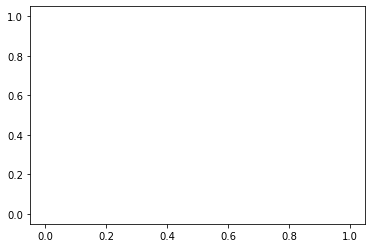

In [85]:
plotSiversQ(3,test_pars,'g')